# Used Car Price Prediction
## Feature Cleaning & Preprocessing

### Objective
This notebook focuses on cleaning and preprocessing feature columns for the
used car price prediction regression problem.

Target variable preprocessing (price cleaning, outlier removal, and log
transformation) has already been finalized in a separate notebook. This notebook
assumes a target-cleaned dataset as input and concentrates only on feature-level
decisions.

### Load Target-Cleaned Dataset

This notebook uses the dataset produced after target variable cleaning
(zero-price removal, outlier handling, and log transformation).

All feature preprocessing steps start from this consistent, cleaned state.


In [1]:
import pandas as pd
import numpy as np

# Load target-cleaned data
df = pd.read_csv("../data/interim/vehicles_target_cleaned.csv")

### Initial Feature Overview

Before applying any feature-level cleaning decisions, we inspect the dataset
structure to understand available features, data types, and missingness.

No transformations are applied at this stage.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392020 entries, 0 to 392019
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            392020 non-null  int64  
 1   url           392020 non-null  object 
 2   region        392020 non-null  object 
 3   region_url    392020 non-null  object 
 4   price         392020 non-null  int64  
 5   year          390905 non-null  float64
 6   manufacturer  376197 non-null  object 
 7   model         387507 non-null  object 
 8   condition     241892 non-null  object 
 9   cylinders     232485 non-null  object 
 10  fuel          389434 non-null  object 
 11  odometer      389752 non-null  float64
 12  title_status  384329 non-null  object 
 13  transmission  390207 non-null  object 
 14  VIN           240518 non-null  object 
 15  drive         272291 non-null  object 
 16  size          110552 non-null  object 
 17  type          306551 non-null  object 
 18  pain

#### Observations
- 

### Handling Missing Values: Year

The `year` feature is directly related to vehicle age and has a strong influence
on price. Because only a very small fraction of rows have missing values for
this column, dropping these rows is preferred over imputation to avoid
introducing bias into the age–price relationship.

In [3]:
# Drop rows with missing year
df = df.dropna(subset=['year'])

#### Observations
- Rows with missing `year` values were dropped.
- The proportion of dropped rows is negligible relative to dataset size.
- Preserving a clean and reliable vehicle age signal is prioritized over
  retaining a small number of incomplete records.

### Handling Missing Values: Odometer

The `odometer` feature is a strong proxy for vehicle usage and directly affects
price. While the column contains missing values, dropping these rows would lead
to significant data loss.

Because mileage is right-skewed, median imputation is preferred over mean
imputation to preserve a realistic central tendency.

In [4]:
# Median imputation for odometer
odometer_median = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(odometer_median)

In [5]:
df['odometer'].isna().sum()

np.int64(0)

#### Observations
- Missing `odometer` values were imputed using the median.
- Median imputation avoids distortion caused by the right-skewed mileage
  distribution.
- This preserves dataset size while maintaining a stable usage–price signal.

### Odometer: Distribution, Invalid Values, and Outlier Handling

In [6]:
df['odometer'].describe()

count    3.909050e+05
mean     9.913574e+04
std      2.052597e+05
min      0.000000e+00
25%      3.904400e+04
50%      8.771250e+04
75%      1.354000e+05
max      1.000000e+07
Name: odometer, dtype: float64

In [7]:
# Check invalid values
(df['odometer'] <= 0).sum()

np.int64(1093)

In [8]:
# Check extreme upper values
df['odometer'].quantile([0.95, 0.99, 0.995, 0.999])

0.950     205396.4
0.990     280000.0
0.995     347000.0
0.999    1111120.6
Name: odometer, dtype: float64

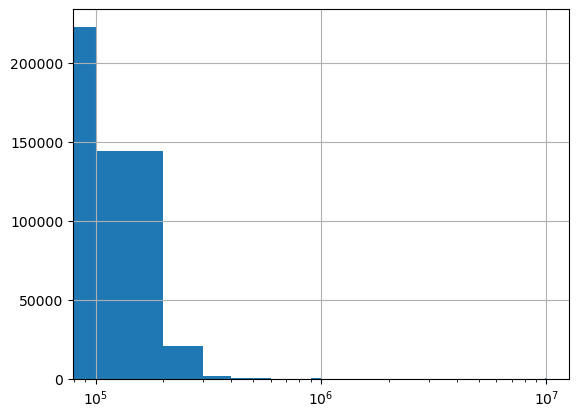

In [9]:
import matplotlib.pyplot as plt
df['odometer'].hist(bins=100)
plt.xscale('log')

In [10]:
# Treat zero mileage as invalid
df.loc[df['odometer'] == 0, 'odometer'] = np.nan

# Re-impute after fixing invalid zeros
odometer_median = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(odometer_median)

# Cap extreme upper outliers
odometer_cap = df['odometer'].quantile(0.995)
df['odometer'] = df['odometer'].clip(upper=odometer_cap)

#### Observations
- A small number of zero-mileage entries were identified and treated as invalid.
- The odometer distribution is heavily right-skewed with extreme upper outliers.
- Zero values were replaced and median-imputed, and extreme values were capped
  at the 99.5th percentile to stabilize the mileage–price relationship.

### Handling Missing Values: Manufacturer

The `manufacturer` feature has a strong influence on vehicle price. However,
dropping rows with missing manufacturer information would result in unnecessary
data loss, and imputing an existing brand would introduce incorrect signal.

Missing values are therefore filled with an explicit `"unknown"` category.

In [11]:
df['manufacturer'] = df['manufacturer'].fillna('unknown')

#### Observations
- Missing manufacturer values were filled with an explicit `"unknown"` category.
- This preserves dataset size while avoiding the introduction of incorrect brand
  information.
- The model can now learn whether missing manufacturer information itself carries
  any price signal.
  

### Fuel Feature Cleaning: Rare Category Consolidation

The `fuel` feature is an important categorical variable influencing vehicle
price. While missing values are minimal, the column contains several low-frequency
categories.

To reduce noise and improve stability during categorical encoding, fuel types
appearing in fewer than 1% of listings are grouped into a single `"other"` category.

In [12]:
# Frequency distribution of fuel types
fuel_freq = df['fuel'].value_counts(normalize=True)

fuel_freq

fuel
gas         0.845711
other       0.071690
diesel      0.065910
hybrid      0.012553
electric    0.004136
Name: proportion, dtype: float64

In [13]:
# Identify rare fuel categories (< 1%)
rare_fuels = fuel_freq[fuel_freq < 0.01].index

# Consolidate rare categories
df['fuel'] = df['fuel'].replace(rare_fuels, 'other')

df['fuel'].value_counts(normalize=True)

fuel
gas       0.845711
other     0.075825
diesel    0.065910
hybrid    0.012553
Name: proportion, dtype: float64

#### Observations
- The `fuel` column contained a small number of low-frequency categories.
- Fuel types occurring in fewer than 1% of listings were grouped into `"other"`.
- This reduces categorical noise and simplifies downstream encoding without
  discarding data.

### Transmission Feature Cleaning

The `transmission` feature strongly affects vehicle price and buyer preference.
It typically has low cardinality (e.g., automatic vs manual), making it easier
to clean and encode.

We first inspect missing values and category distribution before applying any
transformations.

In [14]:
# Check missing values
df['transmission'].isna().sum()

np.int64(1751)

In [15]:
# Category distribution
df['transmission'].value_counts(normalize=True)

transmission
automatic    0.781595
other        0.157750
manual       0.060655
Name: proportion, dtype: float64

In [16]:
# Fill missing transmission values
df['transmission'] = df['transmission'].fillna('other')

### Drive Feature Cleaning

The `drive` feature represents drivetrain configuration and can influence
vehicle price, especially for SUVs and trucks. However, the column often
contains missing values and low-frequency categories.

We first inspect missingness and category distribution before applying any
cleaning decisions.

In [17]:
# Check missing values
df['drive'].isna().sum()

np.int64(119463)

In [18]:
# Category distribution
df['drive'].value_counts(normalize=True)

drive
4wd    0.440039
fwd    0.357925
rwd    0.202036
Name: proportion, dtype: float64

In [19]:
# Fill missing drive values
df['drive'] = df['drive'].fillna('unknown')

### Condition Feature Audit

The `condition` feature represents the seller-reported state of the vehicle and
has a direct influence on price. However, it is subjective and may contain noise
or inconsistencies.

We first inspect missing values and category distribution before deciding on any
cleaning strategy.

In [20]:
# Check missing values
df['condition'].isna().sum()

np.int64(149013)

In [21]:
# Category distribution
df['condition'].value_counts(normalize=True)

condition
good         0.492261
excellent    0.390927
like new     0.082140
fair         0.027773
new          0.004440
salvage      0.002460
Name: proportion, dtype: float64

In [22]:
# Fill missing condition values
df['condition'] = df['condition'].fillna('unknown')

#### Observations
- The `condition` feature has a clean, interpretable ordinal structure.
- All observed categories are meaningful and retained without consolidation.
- Missing values were filled with an explicit `"unknown"` category to preserve
  data while avoiding incorrect assumptions.

In [23]:
# Check missing values
df['cylinders'].isna().sum()

np.int64(159467)

In [24]:
# Category distribution
df['cylinders'].value_counts(normalize=True)

cylinders
6 cylinders     0.381299
4 cylinders     0.313842
8 cylinders     0.283964
5 cylinders     0.007203
10 cylinders    0.005768
other           0.004628
3 cylinders     0.002597
12 cylinders    0.000700
Name: proportion, dtype: float64

In [25]:
# Fill missing cylinder values
df['cylinders'] = df['cylinders'].fillna('unknown')

#### Observations
- The `cylinders` feature has high missingness and is stored as a categorical
  string (e.g., "4 cylinders").
- Dominant categories (4, 6, 8 cylinders) cover the vast majority of listings,
  while rarer configurations are retained.
- Missing values were filled with an explicit `"unknown"` category to preserve
  data and avoid noisy numeric imputation.

### Type Feature Audit

The `type` feature represents vehicle body style (e.g., sedan, SUV, truck) and
has a strong influence on price. However, it often contains missing values and
low-frequency categories.

We first inspect missingness and category distribution before applying any
cleaning decisions.

In [26]:
# Check missing values
df['type'].isna().sum()

np.int64(85314)

In [27]:
# Category distribution
df['type'].value_counts(normalize = True)

type
sedan          0.261883
SUV            0.229542
pickup         0.133545
truck          0.099044
other          0.064469
coupe          0.058510
hatchback      0.052040
wagon          0.032881
van            0.025753
convertible    0.023885
mini-van       0.014889
offroad        0.001934
bus            0.001626
Name: proportion, dtype: float64

In [28]:
# Fill missing type values
df['type'] = df['type'].fillna('unknown')

#### Observations
- The `type` feature has a clear and interpretable category structure.
- All observed vehicle types are meaningful and retained without consolidation.
- Missing values were filled with an explicit `"unknown"` category to preserve
  data and avoid incorrect assumptions.

### Size Feature Audit

The `size` feature represents the overall vehicle size category and may overlap
partially with vehicle type. We inspect missing values and category distribution
before deciding on any cleaning action.

In [29]:
# Check missing values
df['size'].isna().sum()

np.int64(280353)

In [30]:
# Category distribution
df['size'].value_counts(normalize = True)

size
full-size      0.526901
mid-size       0.288100
compact        0.159111
sub-compact    0.025888
Name: proportion, dtype: float64

In [31]:
# Fill missing size values
df['size'] = df['size'].fillna('unknown')

#### Observations
- The `size` feature has very high missingness.
- Observed size categories are clean, interpretable, and retained as-is.
- Missing values were filled with an explicit `"unknown"` category to preserve
  data and avoid incorrect assumptions.

### Paint Color Feature Audit

The `paint_color` feature represents the exterior color of the vehicle. While it
may have minor influence on price, it is often noisy and contains many missing
values.

We inspect missingness and category distribution before deciding on any cleaning
strategy.


In [32]:
# Check missing values
df['paint_color'].isna().sum()

np.int64(116341)

In [33]:
# Category distribution
df['paint_color'].value_counts(normalize=True)

paint_color
white     0.262722
black     0.211047
silver    0.145248
blue      0.106649
red       0.104271
grey      0.082272
green     0.025659
custom    0.023255
brown     0.022443
yellow    0.007295
orange    0.006702
purple    0.002437
Name: proportion, dtype: float64

In [34]:
# Fill missing paint_color values
df['paint_color'] = df['paint_color'].fillna('unknown')

#### Observations
- The `paint_color` feature has high missingness and a long-tailed but clean
  category distribution.
- All observed colors are meaningful and retained without consolidation.
- Missing values were filled with an explicit `"unknown"` category to preserve
  data while avoiding incorrect assumptions.